In [13]:
## Importing libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score

In [14]:
## Data Cleaning
sample_data = pd.read_csv('../EXAM/data/cleaned_data.csv',encoding='utf-16')
df = pd.DataFrame(sample_data)

# area_code dummy
df['area_code'] = df['area_code'].astype(str)
area_code_dummy = pd.get_dummies(df['area_code'])
df = pd.concat([df,area_code_dummy],axis=1)

In [15]:
## Dataset split
columns_to_drop = ['price','address','city','type','energy', 'year','area_name', 'age_squared', 'area_code','area_digit_1','area_digit_2','area_digit_3','area_digit_4','area_digit_5','area_digit_6','area_digit_7','area_digit_8','area_digit_9', 'Bornholm', 'Byen København', 'Fyn', 'Københavns omegn', 'Nordjylland', 'Nordsjælland', 'Sydjylland', 'Vest- og Sydsjælland', 'Vestjylland', 'Østjylland', 'Østsjælland','owner_expenses']
X,y = df.drop(columns_to_drop,axis=1),df.price
test_size = 0.30 # taking 70:30 training and test set
seed = 17082023 # Random number seeding for repeatability of the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
print(X)

      saledays  living_space  ground_space  rooms  Apartment  Holiday home  \
0        202.0         170.0        1019.0    2.0          0             1   
1          0.0          94.0           0.0    3.0          1             0   
2        255.0         248.0         984.0    8.0          0             0   
3          7.0         107.0           0.0    3.0          1             0   
4          0.0         163.0         858.0    5.0          0             0   
...        ...           ...           ...    ...        ...           ...   
3645      48.0         109.0         506.0    3.0          0             0   
3646      48.0         117.0         800.0    3.0          0             1   
3647     240.0          86.0         103.0    4.0          0             0   
3648      48.0          79.0         829.0    3.0          0             0   
3649      48.0         133.0         129.0    5.0          0             0   

      Terraced house  Villa  land  Energimærke A  ...  9830.0  

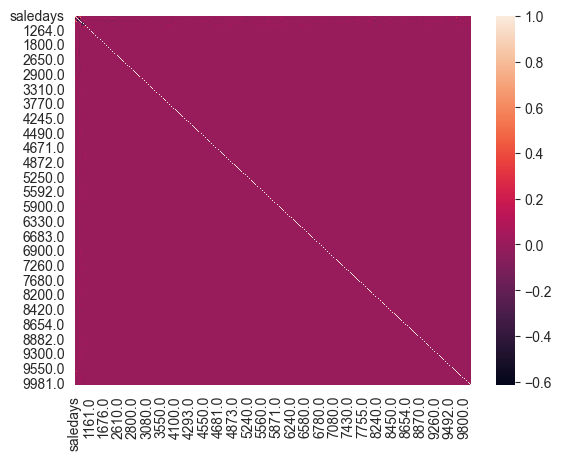

In [16]:
## Heat map
XcorrHeat = sns.heatmap(X.corr())
fig = XcorrHeat.get_figure()
# plt.savefig('Xvar_corr_heat_map.png', bbox_inches='tight')

In [17]:
## Main model
param = {
    'random_state': seed
}

gradient_booster = HistGradientBoostingRegressor(**param)
# Gradient boosting classifiers are required to implement gradient boosting.
gradient_booster.fit(X_train,y_train)
y_test_predict = gradient_booster.predict(X_test)

In [18]:
## R-squared
r2_GBM = r2_score(y_test,y_test_predict)
r2_GBM

0.010875534211344018

In [19]:
## RMSE
RMSE_GBM = mse(y_test,y_test_predict,squared=False)
RMSE_GBM

3102302.276309586

In [20]:
## Define hyperpara
param_grid = {
    # Tree param
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_leaf': list(range(10,100,20)),
    # Boost param
    'learning_rate': [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6],
    # Miscellaneous param
    'random_state':seed
}


In [21]:
## 10-fold cross validation
num_folds = 10
kfolds = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_score = float('-inf')
best_params = {}

for min_samples_leaf in param_grid['min_samples_leaf']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            params = {
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                # Boost param
                'learning_rate': learning_rate,
                # Miscellaneous param
                'random_state':seed
            }


        model = HistGradientBoostingRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=kfolds, scoring='neg_mean_squared_error')
        avg_score = np.mean(scores)

        if avg_score > best_score:
            best_score = avg_score
            best_params = params

print("Best Parameters:", best_params)
print("Best Train RMSE:", np.sqrt(-best_score))  # Convert back to positive mean squared error

# Fitting the model with best para
final_model = HistGradientBoostingRegressor(**best_params)
final_model.fit(X_train, y_train)

y_test_predict = final_model.predict(X_test)

Best Parameters: {'max_depth': 1, 'min_samples_leaf': 10, 'learning_rate': 1.6, 'random_state': 17082023}
Best Train RMSE: 3017570.595869569


In [22]:
## R-squared
r2_HGBM = r2_score(y_test,y_test_predict)
r2_HGBM

0.14062001929568435

In [23]:
## RMSE
RMSE_HGBM = mse(y_test,y_test_predict,squared=False)
RMSE_HGBM

2891686.8211389016

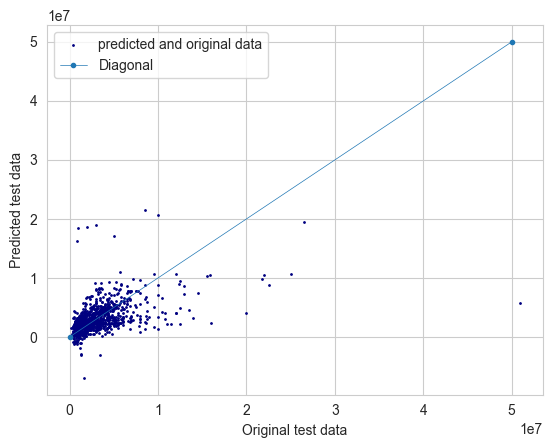

In [25]:
## plotting predicted data against real data

plt.scatter(y_test,y_test_predict, s= 1,c='navy',label='predicted and original data')
plt.plot([0,50000000],[0,50000000], linewidth=0.5,marker='.',label='Diagonal')
plt.xlabel('Original test data')
plt.ylabel('Predicted test data')
plt.legend()
plt.savefig('../EXAM/figs/HGBM_ori_vs_pred',bbox_inches='tight')
plt.show()